# Proceso  de compra de vacunas segun la llegada 

Utilizando la tarea de prediccion de llegada de vacunas y el reciento de vacunancion , realizar un sistema que permita simular y correlacionar el proceso de llegada/compras de vacuna con el proceso de vacunacion, en donde si no se tiene un stock/numero de vacunas las personas tendran que esperar/reasignar a otro dia en donde exista vacunas dentro del establecimiento y realizar el proceso de vacunacion.

In [43]:
import simpy
import random 
import datetime as dt
from datetime import datetime

In [44]:
MESAS = 10 
TIEMPO_VACUNACION = 5
SEMANAS = 2
TIEMPO_SIMULACION =  SEMANAS *3*9*60
CONTROL_SIGNOS = 1
TIEMPO_POST_VACUNA = 20

tiempo_vacunacion={}
cont={0:1}
FECHA_ACTUAL = datetime.now().strftime('%d/%m/%Y')

In [45]:
personas_reasignadas={}
tiempo_vacunacion={}
estado_personas={}

In [46]:
class VacunasEstado():
    def __init__(self, env):
        self.env = env
        self.dispensador = simpy.Resource(env, capacity=MESAS)
        self.bodega = simpy.Container(env, init=350, capacity=800)
        self.monitoreo = env.process(self.monitoreo_bodega())
    def monitoreo_bodega(self,):
        while True:
            if self.bodega.level <= 10:
                self.logs_procesos('++++','Solicitar nuevas vacunas ', self.env.now)
                env.process(self.solicitar_vacunas())
            yield self.env.timeout(15)
    def solicitar_vacunas(self,):
        yield self.env.timeout(50)
        self.logs_procesos('','llega suministro vacunas ',self.env.now)
        nivel = self.bodega.capacity - self.bodega.level
        if nivel ==0:
            nivel+=1
        yield self.bodega.put(nivel)
        
    def logs_procesos(self,icon, accion, hora):
        print(" %s accion:  [%s] hora:  [%d] "%(icon, accion, hora))

In [47]:
class Vacunacion():
    def __init__(self, env, nombre, estadoVacunas):
        self.env = env
        self.nombre = nombre 
        self.estado_vacunas = estadoVacunas
        self.proceso = env.process(self.proceso_vacunacion())
        self.personas_vacunadas = 0
    def control_signos(self):
        yield self.env.timeout(random.randint(CONTROL_SIGNOS, CONTROL_SIGNOS+2))
    
    def logs_procesos(self,icon,nombre, accion, hora):
        print(" %s nombre: [%s] accion:  [%s] hora:  [%d] "%(icon,nombre, accion, hora))
    
    def aplicar_vacuna(self):
        yield self.env.timeout(random.randint(TIEMPO_VACUNACION, TIEMPO_VACUNACION+5))
        
    def post_vacuna(self, tiempo):
        yield self.env.timeout(tiempo)
    
    def proceso_vacunacion(self,):
        while True:
            nombre= 'persona '+str(cont[0])
            cont[0]=cont[0]+1
            self.logs_procesos("--->",nombre," llega al recinto",self.env.now)
            estado_personas[nombre]='cola'
            yield env.process(self.control_signos())
            if random.randint(1,100) > 10:
                self.logs_procesos("", nombre, "pasa el control", env.now)
                estado_personas[nombre]='pasa control'
                inicio_vacunacion =  self.env.now
                if self.estado_vacunas.bodega.level >=1:
                    yield env.process(self.aplicar_vacuna())
                    estado_personas[nombre]='vacunado'
                    self.estado_vacunas.bodega.get(1)
                    tiempo_vacunacion[nombre] = self.env.now - inicio_vacunacion
                    self.logs_procesos("", nombre, "fue vacunada ", self.env.now)
                    yield env.process(self.post_vacuna(TIEMPO_POST_VACUNA))
                    self.logs_procesos("", nombre, "sin complicaciones", self.env.now)
                    self.personas_vacunadas += 1
                    estado_personas[nombre]='completo'
                    
                else:
                    prox_cita = datetime.strftime(datetime.strptime(FECHA_ACTUAL, '%d/%m/%Y')+dt.timedelta(days=3), '%d/%m/%Y')
                    print("--XX-- No hay vacunas para %s, reasignado fecha para: %s"%(nombre, prox_cita))
                    personas_reasignadas[nombre]='reasignado'
                    estado_personas[nombre]='reasignado'
                                
            else:
                self.logs_procesos("", nombre,"no pasa el control", self.env.now)
                estado_personas[nombre]='no control'

# Ejecucion de la simulacion

In [48]:
env = simpy.Environment()

vacunasEstado = VacunasEstado(env)
vacunacion =[Vacunacion(env,"Mesa %d"% i, vacunasEstado) for i in range(MESAS)]
env.run(until=TIEMPO_SIMULACION)
print("Simulacion realizada despues de %d semanas"%SEMANAS)
for i in vacunacion:
    print("[%s] ha vacunado a [%d] personas"%(i.nombre,i.personas_vacunadas))

 ---> nombre: [persona 1] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 2] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 3] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 4] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 5] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 6] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 7] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 8] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 9] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 10] accion:  [ llega al recinto] hora:  [0] 
  nombre: [persona 3] accion:  [pasa el control] hora:  [2] 
  nombre: [persona 5] accion:  [pasa el control] hora:  [2] 
  nombre: [persona 6] accion:  [pasa el control] hora:  [2] 
  nombre: [persona 10] accion:  [pasa el control] hora:  [2] 
  nombre: [persona 1] accion:  [no pasa el control] hora:  [3] 
 ---> nombre: [perso

  nombre: [persona 977] accion:  [sin complicaciones] hora:  [2321] 
 ---> nombre: [persona 988] accion:  [ llega al recinto] hora:  [2321] 
  nombre: [persona 980] accion:  [sin complicaciones] hora:  [2321] 
 ---> nombre: [persona 989] accion:  [ llega al recinto] hora:  [2321] 
  nombre: [persona 984] accion:  [fue vacunada ] hora:  [2321] 
  nombre: [persona 978] accion:  [sin complicaciones] hora:  [2322] 
 ---> nombre: [persona 990] accion:  [ llega al recinto] hora:  [2322] 
  nombre: [persona 987] accion:  [no pasa el control] hora:  [2322] 
 ---> nombre: [persona 991] accion:  [ llega al recinto] hora:  [2322] 
  nombre: [persona 988] accion:  [no pasa el control] hora:  [2322] 
 ---> nombre: [persona 992] accion:  [ llega al recinto] hora:  [2322] 
  nombre: [persona 989] accion:  [pasa el control] hora:  [2322] 
  nombre: [persona 992] accion:  [pasa el control] hora:  [2323] 
  nombre: [persona 990] accion:  [pasa el control] hora:  [2324] 
  nombre: [persona 981] accion:  

# Resultados

In [16]:
no_control=[key for key in list(estado_personas.keys()) if estado_personas[key]=='no control']
vacunados=[key for key in list(estado_personas.keys()) if estado_personas[key]=='completo']
reasignados=[key for key in list(estado_personas.keys()) if estado_personas[key]=='reasignado']
print('-'*70,'\nTotal personas: ', len(estado_personas))
print('Personas que no pasaron el control: ', len(no_control))
print('Personas vacunadas: ', len(vacunados))
print('Personas que fueron reasignados por falta de stock: ', len(reasignados))

---------------------------------------------------------------------- 
Total personas:  2302
Personas que no pasaron el control:  224
Personas vacunadas:  1786
Personas que fueron reasignados por falta de stock:  242


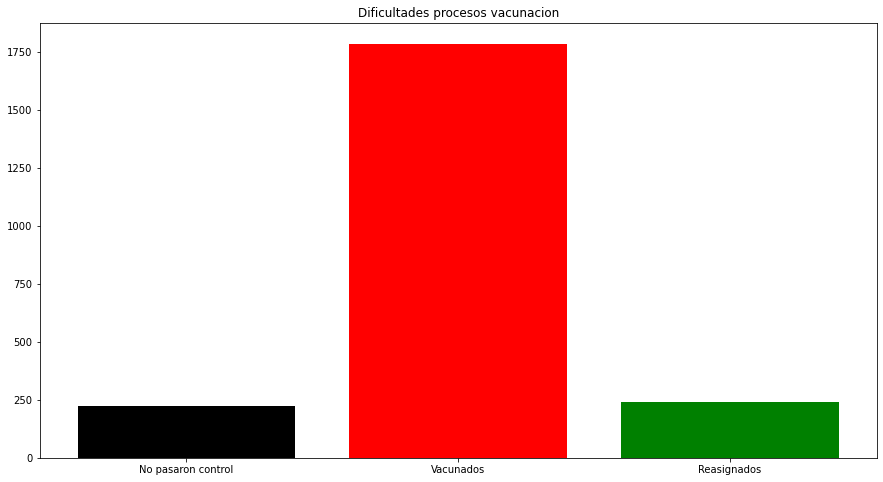

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
resl = [len(no_control), len(vacunados), len(reasignados)]
etiquetas = ['No pasaron control','Vacunados','Reasignados']

plt.bar(etiquetas, resl,color=['black', 'red', 'green'])

plt.title('Dificultades procesos vacunacion')
plt.show()